# SIAMESE NETS

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence


import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/kaigorodov/myprojects/MedConcNorm/')

In [2]:
from src.data.class_balancing import class_sampler
from src.support_models.triplet_generator import TripletGenerator
from src.support_models.loss_functions import triplet_loss, identity_loss
from src.support_models.base_model import base_model
from src.support_models.siamese_model_architecture import siamese_model
from src.support_models.siamese_metric_learner import SiameseMetricLearner

from tqdm import tqdm

Create random configuration
create config: 'temp/run_config_default_run_name.yml'


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaigorodov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kaigorodov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train = pd.read_csv('../../data/interim/cadec/train.csv')
test = pd.read_csv('../../data/interim/cadec/test.csv')

In [4]:
train

,term,start,end,sent,text,code,STR,SNMS
0,back ache,29,38,"After the last pill, have been sick to my stom...","Feels like menstrual cramps, back ache, sick t...",10003993,Backache,"['Back pain', 'Back pain', 'Back pain', 'Back ..."
1,sight gets tired,233,243,"At the start of the second week, I accidentall...",- Chest muscle pains.<SENT>- Pins and needles ...,10049755,Eye strain,"['Asthenopia', 'Accommodative asthenopia', 'Ac..."
2,burning ankles,27,33,The ball of the foot would feel as if it was i...,"Swollen , burning feet and ankles.<SENT>The ba...",10006784,Burning sensation,"['Burning sensation', 'Sensation of burning of..."
3,extreme tiredness,42,59,Perhaps the effects were slower because he was...,"Husband gradually developed muscle pains, extr...",10016256,Fatigue,"['Fatigue', 'Fatigue', 'Fatigue', 'Tiredness',..."
4,i felt like I always had the flu,358,390,Do the benefits outweigh the severe side effec...,On 10 mg.<SENT>didnt seem to have any side eff...,10022004,Influenza like illness,"['Influenza-like illness', 'Influenza-like ill..."
...,...,...,...,...,...,...,...,...
3515,extreme pain in neck,150,154,Ice and ibruprofen gel help but only for a sho...,I started taking Lipitor in December 2009 and ...,10033371,Pain,"['Pain', 'Pain', 'Pain', 'Pain', 'Pain', 'Pain..."
3516,severe muscle pain,0,18,severe muscle pain.,severe muscle pain.<SENT>could not lie on eith...,10033371,Pain,"['Pain', 'Pain', 'Pain', 'Pain', 'Pain', 'Pain..."
3517,twitching mouth,84,99,Symptoms have been gradual over the years with...,"headaches, face and scalp tingling, scalp itch...",10045198,Twitching,"['Muscle twitch', 'Twitching', 'Twitch', 'Musc..."
3518,tire very quickly muscles,24,41,Calf muscles (and foot) tire very quickly.,Calf muscles (and foot) tire very quickly.<SEN...,10049565,Muscle fatigue,"['Muscle fatigue', 'Muscular fatigue', 'Muscul..."


# create model embedding

In [5]:
from gensim.models import FastText
from gensim.test.utils import common_texts
from gensim.utils import tokenize

sentences = pd.read_csv('../../data/interim/cadec/test.csv')['text'].apply(
                lambda x: x.lower().split('<SENT>')).explode().apply(lambda x: list(tokenize(x))).to_list()

embed_dim = 100
nb_words = 3000

ftmodel = FastText(size=embed_dim, window=5, min_count=1)
ftmodel.build_vocab(sentences=sentences)
ftmodel.train(sentences=sentences, total_examples=len(sentences), epochs=10)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=nb_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False
)

tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

nb_words = min(nb_words, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ftmodel[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
        
word_seq_train = tokenizer.texts_to_sequences(train['term'])
word_seq_test = tokenizer.texts_to_sequences(test['term'])

max_seq_len = 15

X_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
X_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

labels = pd.read_csv('../../data/interim/meddra_codes_terms_synonims.csv')
labels = labels['CODE']
meddra_labels = {v:k for k, v in enumerate(labels.unique())}

y_train = train['code'].apply(lambda x: meddra_labels[x]).to_numpy()
y_test = test['code'].apply(lambda x: meddra_labels[x]).to_numpy()

number_of_classes = labels.unique().shape[0]

In [6]:
X_train

array([[   0,    0,    0, ...,    0,   32,  467],
       [   0,    0,    0, ..., 1182, 1224,  282],
       [   0,    0,    0, ...,    0,  409,  406],
       ...,
       [   0,    0,    0, ...,    0,  578, 1035],
       [   0,    0,    0, ...,   60, 1032,  160],
       [   0,    0,    0, ...,    0,  153, 2139]], dtype=int32)

In [7]:
from keras.layers import BatchNormalization, Embedding
from keras.layers import Bidirectional, LSTM, Dense, Dropout

import tensorflow as tf

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Lambda
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling1D


def base_model_lstm(embedding_matrix):
    model = tf.keras.Sequential()
    model.add(Embedding(nb_words, embed_dim, input_length=max_seq_len, 
                        weights=[embedding_matrix],trainable=False))
    model.add(Bidirectional(LSTM(32, return_sequences= True)))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Flatten())
    #model.summary()
    return model

In [8]:
def siamese_model_lstm(base_model, triple_loss_function, identity_loss_function, learning_rate=0.001):
    input_1 = Input(shape=(max_seq_len,), dtype='int32')
    input_2 = Input(shape=(max_seq_len,), dtype='int32')
    input_3 = Input(shape=(max_seq_len,), dtype='int32')

    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)

    loss = Lambda(triple_loss_function)([A, P, N])
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss_function, optimizer=Adam(learning_rate))
    return model

In [9]:
np.unique(y_train).shape, np.unique(y_test).shape

((526,), (251,))

(<AxesSubplot:ylabel='Count'>, <AxesSubplot:ylabel='Count'>)

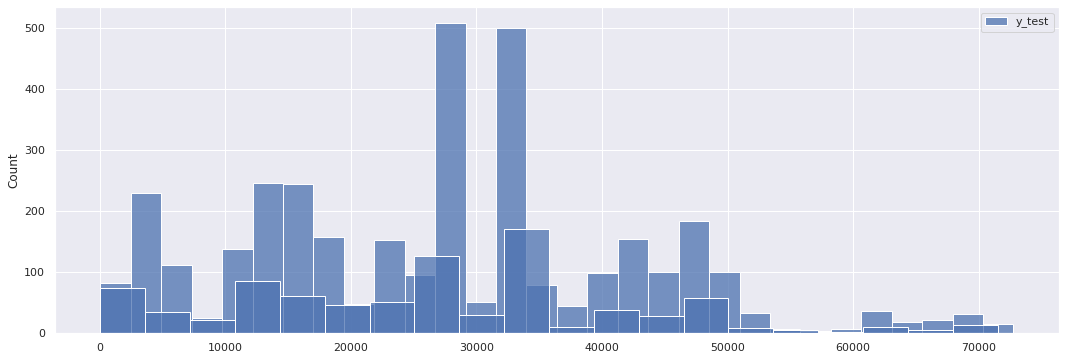

In [10]:
import pandas as pd
import seaborn as sns

plt.figure(figsize=(18, 6))
sns.histplot(pd.DataFrame({'y_train':y_train})), sns.histplot(pd.DataFrame({'y_test':y_test}))

In [11]:
sent_emb = 768
batch_size = 256
lr = 1e-3
EPOCHS = 5
alpha = 0.2 

tgen = TripletGenerator()
train_generator = tgen.generate_triplets(X_train, y_train, batch_size)
test_generator = tgen.generate_triplets(X_test, y_test, batch_size)

labels = np.unique(np.concatenate([y_train, y_test]))

In [12]:
X_train[4]

array([  0,   0,   0,   0,   0,   0,   0,   2, 104,  52,   2, 278,  20,
         4, 297], dtype=int32)

In [13]:
next(train_generator)

([array([[  0.,   0.,   0., ...,   0.,  27.,  11.],
         [  0.,   0.,   0., ...,   0.,   0., 149.],
         [  0.,   0.,   0., ...,   0.,   0.,  11.],
         ...,
         [  0.,   0.,   0., ...,  10., 105., 212.],
         [  0.,   0.,   0., ...,   0.,   0., 176.],
         [  0.,   0.,   0., ...,   0.,   0., 129.]], dtype=float32),
  array([[  0.,   0.,   0., ...,   0.,  27., 129.],
         [  0.,   0.,   0., ...,   0.,   0., 309.],
         [  0.,   0.,   0., ..., 146., 267.,  11.],
         ...,
         [  0.,   0.,   0., ..., 129.,  10., 245.],
         [  0.,   0.,   0., ...,   0.,   0., 176.],
         [  0.,   0.,   0., ...,  11.,  10., 245.]], dtype=float32),
  array([[  0.,   0.,   0., ...,   0.,   0.,  11.],
         [  0.,   0.,   0., ...,  10.,  95., 160.],
         [  0.,   0.,   0., ..., 812.,  14.,  37.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0., 236.],
         [  0.,   0.,   0., ...,   0.,   0., 333.],
         [  0.,   0.,   0., ..., 828.,  

In [14]:


# emb_model = base_model(sent_emb)
# model = siamese_model(emb_model, sent_emb, triplet_loss, identity_loss, learning_rate=lr)

emb_model = base_model_lstm(embedding_matrix)
model = siamese_model_lstm(emb_model, triplet_loss, identity_loss, learning_rate=lr)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 750)          337778      input_1[0][0]                    
                                                                 input_2[0][0]                

In [15]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [16]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=EPOCHS, 
                              verbose=1, 
                              workers=10,
                              use_multiprocessing=True,
                              steps_per_epoch=20, 
                              validation_steps=10,
                             callbacks=[early_stopping_callback])

Epoch 1/5
20/20 [==============================] - 22s 758ms/step - loss: 0.5149 - val_loss: 0.3459
Epoch 2/5
20/20 [==============================] - 7s 372ms/step - loss: 0.3078 - val_loss: 0.2639
Epoch 3/5
20/20 [==============================] - 10s 506ms/step - loss: 0.2363 - val_loss: 0.2315
Epoch 4/5
20/20 [==============================] - 10s 526ms/step - loss: 0.1917 - val_loss: 0.2212
Epoch 5/5
20/20 [==============================] - 10s 545ms/step - loss: 0.1765 - val_loss: 0.1963


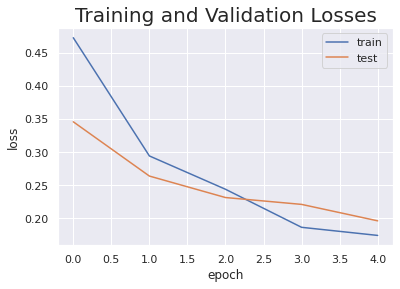

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [18]:
X_train_trm = emb_model.predict(X_train.reshape(-1, sent_emb, 1))
X_test_trm = emb_model.predict(X_test.reshape(-1, sent_emb, 1))
X_train.shape, X_train_trm.shape, X_test.shape, X_test_trm.shape

ValueError: cannot reshape array of size 52800 into shape (768,1)

# Show changes

In [ ]:
def scatter(x, labels, subtitle=None):
    palette = np.array(sns.color_palette("hls", 500))
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40, c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

In [ ]:
# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne = tsne.fit_transform(X_train)
print(train_tsne.shape, y_train.shape)
scatter(train_tsne, y_train)

In [ ]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)
print(train_tsne_embeds.shape, y_train.shape)
scatter(train_tsne_embeds, y_train)

In [ ]:
tsne = TSNE()
test_tsne = tsne.fit_transform(X_test)
print(test_tsne.shape, y_test.shape)
scatter(test_tsne, y_test)

In [ ]:
tsne = TSNE()
test_tsne_embeds = tsne.fit_transform(X_test_trm)
print(test_tsne_embeds.shape, y_test.shape)
scatter(test_tsne_embeds, y_test)

In [ ]:
tsne = TSNE(n_components=3)
train_to_classify = tsne.fit_transform(X_train_trm)
test_to_classify = tsne.fit_transform(X_test_trm)

train_to_classify.shape, test_to_classify.shape

# Classify

In [ ]:
import pandas as pd
import numpy as np
from copy import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pymedtermino

from metric_learn import NCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from tpot import TPOTClassifier

generations = 3
population_size = 20
max_eval_time_mins = 1
n_jobs = 10
max_iter = 10

tpot = TPOTClassifier(generations=generations, 
                      population_size=population_size,
                      verbosity=2, 
                      random_state=42, 
                      max_eval_time_mins=max_eval_time_mins, 
                      n_jobs=n_jobs)

tpot.fit(train_tsne_embeds, y_train)

In [ ]:
score = tpot.score(train_tsne_embeds, y_train)
score

In [ ]:
score = tpot.score(test_tsne_embeds, y_test)
score

score was with low alpha = 0.17439703153988867
score was with 0.2 alpha = 0.11873840445269017

In [ ]:
y = np.array([2, 3 , 4, 5, 1, 2, 0 ,1, 2])
d = np.array([324, 656, 55453, 2342, 5464, 3244, 23, 545, 23243])

y[np.argmin(d)]

In [ ]:
y = np.array([1, 2, 2, 1, 0 ,0 ,0, 1]*3)
d = np.array([2333, 232, 13423, 32423 ,234324, 234, 4545, 23]*3)

np.argpartition(d, y.shape[0]-1)[:], y[np.argpartition(d, y.shape[0]-1)[:]]

In [ ]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((10,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(y_train, 10)[:sample_size]
Y_test_onehot = np_utils.to_categorical(y_test, 10)[:sample_size]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=10)

In [ ]:
# from google.colab import files
# import io
# uploaded = files.upload()


In [ ]:
# def gini(x):
#     # calculates the gini coeffiecent of 
#     # an array. 
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     rmad = mad/np.mean(x)
#     g = 0.5 * rmad
#     return g

# def DigitOrNumber(x):
#   # Creates an embedding for an image and then calculates the 
#   # equality of the softmax prediction distribution if it is below a certain threshold
#   # then the image will be classified as a digit
#   temp = base_model.predict(x)
#   temp = Classifier_model.predict(temp)
#   if gini(temp) < 0.87:
#     print(np.argmax(temp))
#   else:
#     print('Input is not a Digit')
    
# # a few examples
# x= np.load(io.BytesIO(uploaded['emnist_train_images_3 (1).npy'])) 
# DigitOrNumber(x[0:1])
# DigitOrNumber(x[1:2])
# DigitOrNumber(x[2:3])
# DigitOrNumber(X_test[20:21])
# DigitOrNumber(X_test[500:501])
# DigitOrNumber(X_test[1007:1008])